In [1]:
!pip install -q colour-science

     |████████████████████████████████| 2.1 MB 8.7 MB/s 


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import csv
import colour
from scipy.optimize import differential_evolution

In [3]:
root_directory = "/content/drive/MyDrive/Mi_FFI/CalibracionBienOrganizado"

In [4]:
# Define the path of the images folder
folder_img_carne = root_directory+"/imagenes_carne"
folder_img_paleta = root_directory+"/imagenes_paletas"

In [5]:
def find_circles(paleta):
    """
    Finds circles in the given palette image
    Returns the (x,y) coordinates and the radius of each circle
    """
    gray = cv2.cvtColor(paleta, cv2.COLOR_RGB2GRAY)
    detected_circles = cv2.HoughCircles(gray, 
                        cv2.HOUGH_GRADIENT, 1, 20, param1 = 100,
                    param2 = 25, minRadius = 1, maxRadius = 25)

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))

    return detected_circles[0]

def getColorsMatrix(paleta,detected_circles):
    """
    Gets the median of the color of each circle
    Returns median RGB values for each circle in the image
    """
    my_circles = deepcopy(detected_circles)
    circles_column_idx = np.argsort(my_circles[:,0])
    circ_sorted_x = deepcopy(my_circles[circles_column_idx,:])

    circ_split = np.array_split(circ_sorted_x,4)

    circ_sorted_y = np.zeros_like(circ_split)
    for k in range(len(circ_split)):
        circles_row_idx = np.argsort(circ_split[k][:,1])
        circ_sorted_y[k] = deepcopy(circ_split[k][circles_row_idx,:])
    
    rows,cols,_ = circ_sorted_y.shape
    my_circles = np.reshape(circ_sorted_y,(rows*cols,_))

    median_array = np.zeros((len(my_circles),3))
    for k in range(len(my_circles)):
        (x,y,r) = my_circles[k]
        
        median_r = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),0])
        median_g = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),1])
        median_b = np.median(paleta[y-(r//2):y+(r//2),x-(r//2):x+(r//2),2])
        
        median_array[k] = (median_r,median_g,median_b)
    
    return my_circles,median_array

In [6]:
# List all the meat images
files = os.listdir(folder_img_carne)
files[:5]

['20210908_S01_9_c.JPG',
 '20210910_S01_7_c.JPG',
 '20210910_S01_6_c.JPG',
 '20210910_S01_8_c.JPG',
 '20210910_S01_9_c.JPG']

## NOTA: la paleta de calibración debe de estar en la misma carpeta que las paletas de muestra

In [7]:
# Read the calibration palette
paleta_calibracion = cv2.imread(folder_img_paleta+"/CALIBRACION.JPG")
paleta_calibracion = cv2.cvtColor(paleta_calibracion,cv2.COLOR_BGR2RGB)
# Detect the circles in the calibration palette
detected_circles = find_circles(paleta_calibracion)
# Get the median of each color in the calibration palette
circles_cal,median_cal = getColorsMatrix(paleta_calibracion,detected_circles)
median_cal = median_cal.astype("float")
median_cal

array([[ 188. ,  190. ,  203. ],
       [ 148. ,  151. ,  171. ],
       [ 122. ,  121.5,  137. ],
       [  97. ,   95. ,  109. ],
       [  72. ,   71. ,   83.5],
       [  57. ,   55. ,   65.5],
       [ 158. ,   96. ,   96. ],
       [ 146. ,   86. ,   91. ],
       [ 129. ,   73. ,   80.5],
       [ 120. ,   72. ,   77. ],
       [ 114. ,   68. ,   80. ],
       [ 106. ,   71. ,   75. ],
       [ 159. ,  107. ,   71. ],
       [  73. ,   84. ,  155. ],
       [ 157. ,   87. ,  106. ],
       [  86. ,   69. ,  107. ],
       [ 112. ,  149. ,   79. ],
       [ 167. ,  140. ,   71. ],
       [ 177. ,   76. ,   87. ],
       [  77. ,  151. ,   94. ],
       [  72. ,   85. ,  157. ],
       [ 170. ,  166. ,   71. ],
       [ 157. ,   85. ,  136. ],
       [  64. ,  111. ,  160. ]])

## Errores de calibración

In [8]:
carnes = {
    "arrachera":[file for file in files if file.split('_')[1]=="A01"],
    "sirloin":[file for file in files if file.split('_')[1]=="S01"],
    "bola":[file for file in files if file.split('_')[1]=="B01"]
}

arrachera


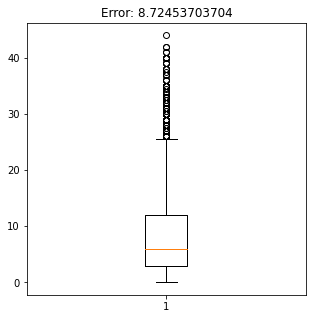

sirloin


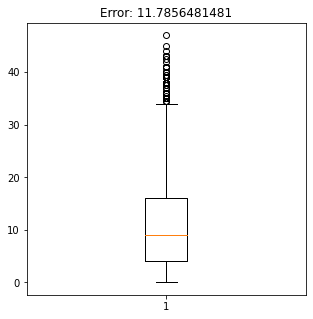

bola


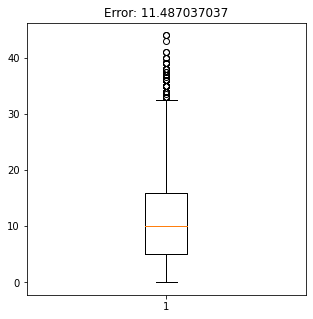

In [10]:
if not os.path.exists(root_directory+"/Errores"):
    os.mkdir(root_directory+"/Errores")

for tipo_carne,archivos in carnes.items():
    if len(archivos)==0:
        continue
    print(tipo_carne)
    if os.path.exists(root_directory+"/Errores/"+tipo_carne+".csv"):
        os.remove(root_directory+"/Errores/"+tipo_carne+".csv")
    
    diff_median = np.zeros((len(archivos),24,3),dtype=float) # Differences between each sample image and the calibration image
    for k,filename in enumerate(archivos):
        img_paleta = cv2.imread(folder_img_paleta+'/'+filename,cv2.IMREAD_COLOR)
        img_paleta = cv2.cvtColor(img_paleta,cv2.COLOR_BGR2RGB)

        detected_circles = find_circles(img_paleta)
        if len(detected_circles) != 24:
            print("There are not 24 circles in the image")
            print(file)
            break

        circles_p,median_p = getColorsMatrix(img_paleta,detected_circles)

        diff_median[k] = np.abs(median_cal-median_p)
        
    flattened = diff_median.flatten()
    with open(root_directory+"/Errores/"+tipo_carne+".csv","a") as file:
        file.write(",".join(flattened.astype("str")))
        file.write("\n")
    
    plt.figure(figsize=(5,5))
    plt.title("Error: "+str(np.average(flattened)))
    plt.boxplot(flattened)
    plt.show()

    